In [3]:
import numpy as np

def somme_des_logs(y):
    sommes = y.copy()
    for i in range(len(y)):
        for j in range(len(y[0])):
            sommes[i][j] = som_des_logs(y[i][j])
    return sommes
 



In [4]:
import math

def som_des_logs(n):
    somme = 0
    for i in range(1, n+1):
        somme += math.log(i)
    return somme


In [79]:
x

array([   0,   10,   33,  100,  333, 1000])

In [80]:
y

array([[15, 16, 16, 27, 33, 20],
       [21, 18, 26, 41, 38, 27],
       [29, 21, 33, 69, 41, 42]])

In [283]:
import numpy as np
import scipy.special

def salm(nchain, x, y, alpha, beta, gamma, tau, lambd, prop_sd):
  
    # Initialisation
    # res = np.ones((nchain + 1, 4))
    res = []
    res.append([alpha, beta, gamma, 1/np.sqrt(tau)])
    res_lambda = []
    res_lambda.append(lambd)
    n = len(x)
    m = y.shape[1]
    logmu = np.zeros((n,m))
    for l in range(n):
        for k in range(m):
            logmu[l, k] = alpha + beta * np.log(10 + x[l]) + gamma * x[l] + lambd[l, k]
    mu = np.exp(logmu)

    
    acc_rates = np.zeros(3) 

    for i in range(nchain):

        lambd = res_lambda[i]
        # Mise à jour de alpha
        alpha = res[i][0]
        prop = np.random.normal(alpha, prop_sd[0])  # marche aléatoire simple
        prop_logmu = np.zeros((n,m))
        for l in range(n):
            for k in range(m):
                prop_logmu[l, k] = prop + beta * np.log(10 + x[l]) + gamma * x[l] + lambd[l, k]
        prop_mu = np.exp(prop_logmu)
        sum_log = somme_des_logs(y)
        top = - ((prop**2) / (2 * 1e6)) + np.sum(y * np.log(prop_mu+1e-10) - sum_log - prop_mu)
        bottom = - ((alpha**2) / (2 * 1e6)) + np.sum(y * np.log(mu) - sum_log - mu)
        acc_prob = np.exp(top - bottom)  # la proportion des noyaux est de 1 (symétrie du noyau)
        
        if np.random.uniform() < min(1, acc_prob):
            alpha = prop
            logmu = prop_logmu
            mu = prop_mu
            acc_rates[0] += 1
        
        # Mise à jour de beta
        print(i)
        beta = res[i][1]
        prop = np.random.normal(beta, prop_sd[1])  # marche aléatoire simple
        for l in range(n):
            for k in range(m):
                prop_logmu[l, k] = alpha + prop * np.log(10 + x[l]) + gamma * x[l] + lambd[l, k]
        prop_mu = np.exp(prop_logmu)
        sum_log = somme_des_logs(y)
        top = - ((prop**2) / (2 * 1e6)) + np.sum(y * np.log(prop_mu+1e-10) - sum_log - prop_mu)
        bottom = - ((beta**2) / (2 * 1e6)) + np.sum(y * np.log(mu) - sum_log - mu)
        acc_prob = np.exp(top - bottom)  # la proportion des noyaux est de 1 (symétrie du noyau)
        
        if np.random.uniform(0, 1) < min(1, acc_prob):
            beta = prop
            logmu = prop_logmu
            mu = prop_mu
            acc_rates[1] += 1
        
        # Mise à jour de gamma
        gamma = res[i][2]
        prop = np.random.normal(gamma, prop_sd[2])  # marche aléatoire simple
        for l in range(n):
            for k in range(m):
                prop_logmu[l, k] = alpha + beta * np.log(10 + x[l]) + prop * x[l] + lambd[l, k]
        prop_mu = np.exp(prop_logmu)
        sum_log = somme_des_logs(y)
        top = - ((prop**2) / (2 * 1e6)) + np.sum(y * np.log(prop_mu+1e-10) - sum_log - prop_mu)
        bottom = - ((gamma**2) / (2 * 1e6)) + np.sum(y * np.log(mu) - sum_log - mu)
        acc_prob = np.exp(top - bottom)  # la proportion des noyaux est de 1 (symétrie du noyau)
        
        if np.random.uniform(0, 1) < min(1, acc_prob):
            gamma = prop
            logmu = prop_logmu
            mu = prop_mu
            acc_rates[2] += 1
        
        # Mise à jour de tau
        tau = np.random.gamma(1e-3 + (n + m) / 2, 1e-3 + 0.5 * np.sum(lambd**2))

        # Mise à jour de lambd
        for k in range(n):
            for l in range(m):
                prop = np.random.normal(lambd[k,l], prop_sd[3])
                for o in range(n):
                    for p in range(m):
                        prop_logmu[o, p] = alpha + beta * np.log(10 + x[o]) + gamma * x[o] + prop
                prop_mu = np.exp(prop_logmu)
                top = - (tau*prop**2 / (2))- prop_mu[k,l] + y[k, l]*np.log(prop_mu[k,l]) - som_des_logs(y[k][l])
                bottom = - (tau*lambd[k, l]**2/ (2))- mu[k,l] + y[k, l]*np.log(mu[k, l]) - som_des_logs(y[k][l])
                acc_prob = np.exp(top - bottom)
              
                if np.random.uniform(0, 1) < min(1, acc_prob):
                    lambd[k, l] = prop
                    logmu= prop_logmu
                    mu = prop_mu
        
        # Mise à jour de la chaîne de Markov et de b
        res.append([alpha, beta, gamma, 1/np.sqrt(tau)])
        res_lambda.append(lambd)
    
    my_list = {"chain": res, "acc_rates": acc_rates}
    return my_list



In [294]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, poisson

# Récupération des données
Ndoses = 6
Nplates = 3
y = np.array([[15, 16, 16],
              [27, 33, 20],
              [21, 18, 26],
              [41, 38, 27],
              [29, 21, 33],
              [60, 41, 42]])
x = np.array([0, 10, 33, 100, 333, 1000])

# Initialisation
alpha = 0.0
beta = 0
gamma = 0
tau = 0.1
lambd = np.random.normal(loc=0, scale=np.sqrt(1/tau), size=(6, 3))

resultat = salm(int(10000), x, y, alpha, beta, gamma, tau, lambd, prop_sd=[0.06, 0.01, 0.001, 10])  # prop_sd choisi pour avoir une apparence de chaîne cohérente

resultat_chain = resultat["chain"][1000:]  # enlever les 1000 premiers (burn-in)

moychain = np.mean(resultat_chain, axis=0)  # moyenne
sdchain = np.std(resultat_chain, axis=0)  # écart-type

print("alpha est estimé à", moychain[0], "avec un écart-type de", sdchain[0])
print("beta est estimé à", moychain[1], "avec un écart-type de", sdchain[1])
print("gamma est estimé à", moychain[2], "avec un écart-type de", sdchain[2])
print("sigma est estimé à", moychain[3], "avec un écart-type de", sdchain[3])



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197


C:\Users\tetoflex\AppData\Local\Temp\ipykernel_620\2948344602.py:37: RuntimeWarning: overflow encountered in exp
  acc_prob = np.exp(top - bottom)  # la proportion des noyaux est de 1 (symétrie du noyau)
C:\Users\tetoflex\AppData\Local\Temp\ipykernel_620\2948344602.py:95: RuntimeWarning: overflow encountered in exp
  acc_prob = np.exp(top - bottom)


198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447


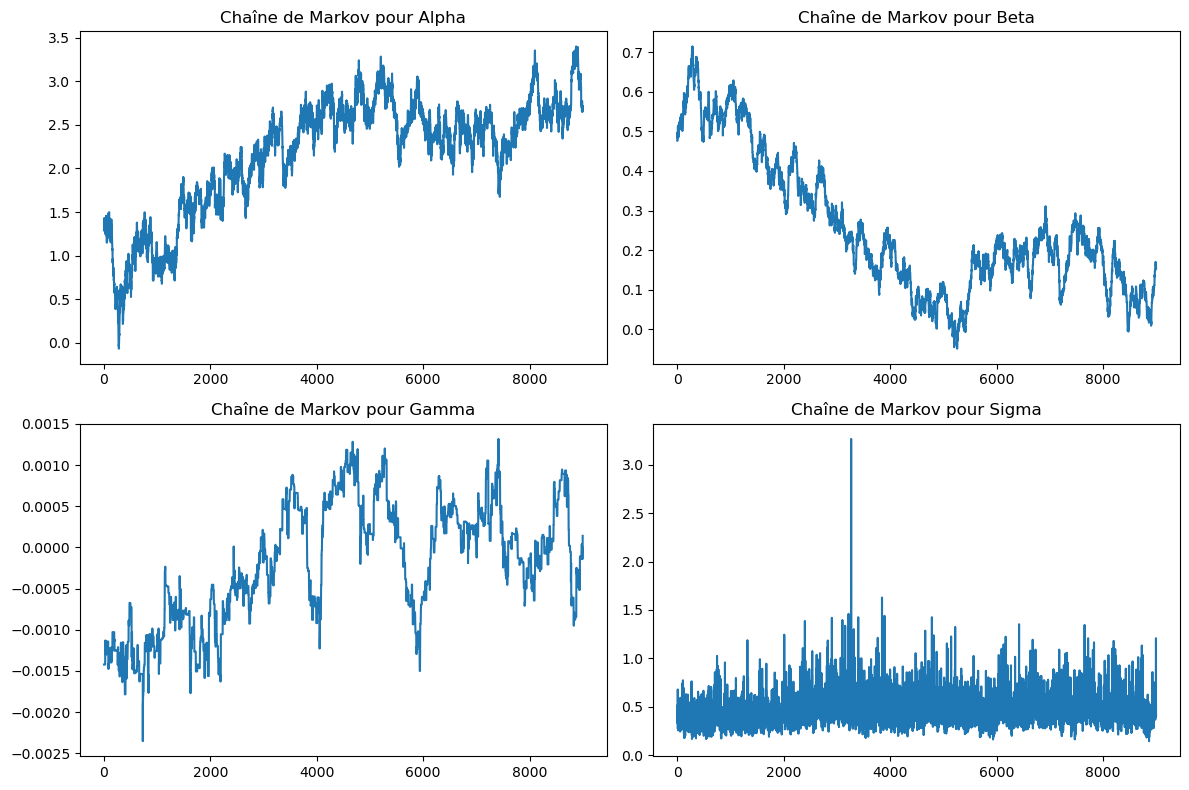

In [295]:
import matplotlib.pyplot as plt

# Obtention des chaînes de Markov pour chaque paramètre
alpha_chain = [item[0] for item in resultat_chain]
beta_chain = [item[1] for item in resultat_chain]
gamma_chain = [item[2] for item in resultat_chain]
sigma_chain = [item[3] for item in resultat_chain]

# Tracé des chaînes de Markov
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(alpha_chain)
plt.title('Chaîne de Markov pour Alpha')

plt.subplot(2, 2, 2)
plt.plot(beta_chain)
plt.title('Chaîne de Markov pour Beta')

plt.subplot(2, 2, 3)
plt.plot(gamma_chain)
plt.title('Chaîne de Markov pour Gamma')

plt.subplot(2, 2, 4)
plt.plot(sigma_chain)
plt.title('Chaîne de Markov pour Sigma')

plt.tight_layout()
plt.show()



In [255]:
resultat["acc_rates"]

array([15975., 12519.,   119.])

In [256]:
#Baseline here indicates Breslow and Clayton estimates
def plot_parameter_comparison(params_df):
    ind = np.arange(len(params_df))  # the x locations for the groups
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind - width / 2, params_df['mean'], width, label='Model', yerr=params_df['std'])
    rects2 = ax.bar(ind + width / 2, params_df['mean_base'], width, label='Baseline', yerr=params_df['std_base'])

    # Add some text for labels, title, and custom x-axis tick labels
    ax.set_ylabel('Values')
    ax.set_title('Model vs. baseline Parameter Comparison')
    ax.set_xticks(ind)
    ax.set_xticklabels(['alpha', 'beta', 'gamma', 'sigma'])
    ax.legend()

    plt.show()

#results_summary = results.describe().T
import pandas as pd
params_df = pd.DataFrame()
params_df['mean'] = mean
params_df['std'] = sd
#Breslow and Clayton estimates
params_df['mean_base'] = [2.193, 0.3059, 69.577*(10**(-4)), 0.2608]
params_df['std_base'] = [0.3874, 0.1054, 4.525*(10**(-4)), 0.08077]
params_df.reset_index(drop=True, inplace=True)

plot_parameter_comparison(params_df)

NameError: name 'mean' is not defined